In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Dense

import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf


In [2]:
def clean_vals(s):
    st = s[1:]
    st = st.replace(",","")
    i = int(st)
    return i


In [3]:
def date_to_qtr(date):
    yr = date[:4]
    q = date[5:7]
    if q == '12':
        qtr = 'Q4'
    if q == '09':
        qtr = 'Q3'
    if q == '06':
        qtr = 'Q2'
    if q == '03':
        qtr = 'Q1'    
    return (yr + " " + qtr)


In [4]:
def get_merged_dataset(query):
    sc = pd.read_csv("../../data/raw/dfast/Historic_Domestic.csv", index_col=False)
    df = pd.read_csv("../../data/raw/uslocs/banks_income_expense_final.csv", index_col=False)

    #query 1 class Tag where query is string like : 'Total Assets:'
    r = df.query(f"Bank == {query}")
    r.drop('Bank', axis=1, inplace=True) # cos why? They are all the same
    #Clean values
    r = r.fillna("$0")
    r.isnull().sum()
    #Transform dates
    cols = [col for col in r.columns]
    columns = cols[1:]    
    for col in columns:
        # print(r[f'{col}'])
        r[f'{col}'] = r[f'{col}'].apply(lambda x : clean_vals(x))
    d2q = {col : date_to_qtr(col) for col in columns}
    n_df = r.rename(columns=d2q)

    

    #Transpose - to bank wise cols
    """Here, each bank col will become a dependent variable, so we will be predicting usng the 18 other 
    eco vars the tag(query) for each bank"""
    n_df = n_df.transpose()
    n_df.columns = n_df.iloc[0]
    ndf = n_df.iloc[1:, :] #setting column headers as bank names
    # this gives a data frame that has banks for columns and values for query with rows as quarters
    
    #map this to scenarios
    #I dont think the scenarios have the same number of years - they have more:')
    # inner join the 2 frames
    ndf['Date'] = ndf.index
    sc["Date"] = sc["Date"].astype(str)
    ndf["Date"] = ndf["Date"].astype(str)
    result = sc.merge(right=ndf, on="Date")
    
    return result #merged df


"""Instead of picking out target variable first, you can pick out bank:
 then you will have a dataset of all vars for a bank, and you can perform macroeco analysis for all of them
 Bank wise
 It will capture more data at one point in time
 this will be bank specific analysis as against predicting the same variable for multiple banks
 This way you can get the consolidated info for a single bank; esp when you construct different models 
 to predict different dependent vars
 """


'Instead of picking out target variable first, you can pick out bank:\n then you will have a dataset of all vars for a bank, and you can perform macroeco analysis for all of them\n Bank wise\n It will capture more data at one point in time\n this will be bank specific analysis as against predicting the same variable for multiple banks\n This way you can get the consolidated info for a single bank; esp when you construct different models \n to predict different dependent vars\n '

In [5]:
# q = "'Total Assets:'"
# q = "'Total noninterest income'"
# q = "'Home equity lines of credit - total recoveries'"
# q = "'Salaries and employee benefits'"

q = "'jpmorgan-chase-bank'"
blah = get_merged_dataset(q)

C:\Users\18055\AppData\Local\Temp\ipykernel_12556\2005083813.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r.drop('Bank', axis=1, inplace=True) # cos why? They are all the same
C:\Users\18055\AppData\Local\Temp\ipykernel_12556\2005083813.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf['Date'] = ndf.index
C:\Users\18055\AppData\Local\Temp\ipykernel_12556\2005083813.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [6]:
blah.head()

,Scenario Name,Date,Real GDP growth,Nominal GDP growth,Real disposable income growth,Nominal disposable income growth,Unemployment rate,CPI inflation rate,3-month Treasury rate,5-year Treasury yield,...,Other Consumer Loans Net Charge-Offs,Loans to foreign governments and official institutions,Other loans,Lease financing receivables,Loans to finance agricultural production and other loans to farmers,Cash dividends,Cash dividends declared on preferred stock,Cash dividends declared on common stock,Interest income: Foreign office loans,Interest expense: Foreign office deposits
0,Actual,1993 Q4,5.6,7.9,2.8,5.2,6.6,3.4,3.1,5.0,...,15000000,35000000,53000000,0,0,400000000,0,400000000,1089000000,1019000000
1,Actual,1994 Q4,4.7,7.0,5.9,7.9,5.6,2.3,5.3,7.6,...,7000000,307000000,16000000,0,0,1000000000,0,1000000000,1080000000,1192000000
2,Actual,1995 Q4,2.7,4.7,2.3,4.1,5.6,2.2,5.3,5.7,...,12000000,0,-9000000,0,0,560000000,0,560000000,1457000000,1931000000
3,Actual,1996 Q4,4.2,6.5,2.0,4.8,5.3,3.5,5.0,6.1,...,39000000,-2000000,-7000000,7000000,0,1230000000,0,1230000000,3828000000,3512000000
4,Actual,1997 Q4,3.5,4.8,6.0,7.4,4.7,2.2,5.1,5.9,...,55000000,-3000000,-18000000,12000000,0,1650000000,0,1650000000,2895000000,3533000000


## Correlation

In [7]:
# all correlations
date = blah["Date"].to_list()
data = blah.iloc[:,2:].astype('float32')

In [8]:
def change_names(df):
    df = df.rename(columns={'Unemployment rate': 'unempr', 
                    'House Price Index (Level)':'houseprice', 
                    'Commercial Real Estate Price Index (Level)' : 'realEstate',
                    '10-year Treasury yield' : 'ten', "5-year Treasury yield" : 'five',
                    '3-month Treasury rate': 'threemon', 'CPI inflation rate' : 'cpiInflation', 
                    'Dow Jones Total Stock Market Index (Level)': "djstock", 
                    "Market Volatility Index (Level)":'market', 'BBB corporate yield':'corpyeild', 'Mortgage rate':'mortgage',
                    'Prime rate':'prime', 'Nominal disposable income growth': 'nom_incgrowth',
                    'Real disposable income growth':'real_incgrowth','Real GDP growth': 'realgdp','Nominal GDP growth':'nomgdp'})
    return df

In [9]:
data = change_names(data)

In [10]:
def add_lags(df):
    cols = df.iloc[:,:16].columns
    for col in cols:
        df[f"lag{col}"] = df[col].shift(1)
    return df
data = add_lags(data)
# corrs = data.corr()
# corrs

In [11]:
# rearranging cols
pred_df = data.iloc[:,:16]
pred_df = pd.concat([pred_df, data.iloc[:,-16:]], ignore_index=False, axis=1)
pred_df = pd.concat([pred_df, data.iloc[:,17:-16]], ignore_index=False, axis=1)
corrs = pred_df.corr()
corrs

,realgdp,nomgdp,real_incgrowth,nom_incgrowth,unempr,cpiInflation,threemon,five,ten,corpyeild,...,Other Consumer Loans Net Charge-Offs,Loans to foreign governments and official institutions,Other loans,Lease financing receivables,Loans to finance agricultural production and other loans to farmers,Cash dividends,Cash dividends declared on preferred stock,Cash dividends declared on common stock,Interest income: Foreign office loans,Interest expense: Foreign office deposits
realgdp,1.000000,0.962269,-0.395169,-0.326202,-0.171038,0.320671,0.072989,0.064959,0.044718,-0.163166,...,-0.085047,0.052479,0.049083,0.063921,NaN,-0.000848,NaN,-0.000848,0.008944,-0.068667
nomgdp,0.962269,1.000000,-0.408678,-0.298641,-0.244481,0.500538,0.090701,0.075515,0.030712,-0.214682,...,-0.161586,0.045978,0.029908,0.046069,NaN,-0.030330,NaN,-0.030330,0.008824,-0.086185
real_incgrowth,-0.395169,-0.408678,1.000000,0.975627,0.140163,-0.296001,0.034018,-0.006900,-0.024174,-0.016196,...,-0.042112,0.035630,-0.078631,-0.008718,NaN,-0.004803,NaN,-0.004803,-0.083016,-0.032564
nom_incgrowth,-0.326202,-0.298641,0.975627,1.000000,0.078632,-0.084522,0.069598,0.024462,-0.006499,-0.061092,...,-0.089930,0.034283,-0.070134,-0.012200,NaN,-0.009770,NaN,-0.009770,-0.090798,-0.047035
unempr,-0.171038,-0.244481,0.140163,0.078632,1.000000,-0.286792,-0.550889,-0.426210,-0.214573,-0.022737,...,0.441312,-0.014897,0.268015,-0.018247,NaN,-0.211096,NaN,-0.211096,-0.279426,-0.242523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cash dividends,-0.000848,-0.030330,-0.004803,-0.009770,-0.211096,0.000164,0.208586,0.023091,-0.087179,-0.059065,...,-0.053204,-0.056293,0.564271,-0.160809,NaN,1.000000,NaN,1.000000,0.577726,0.440780
Cash dividends declared on preferred stock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cash dividends declared on common stock,-0.000848,-0.030330,-0.004803,-0.009770,-0.211096,0.000164,0.208586,0.023091,-0.087179,-0.059065,...,-0.053204,-0.056293,0.564271,-0.160809,NaN,1.000000,NaN,1.000000,0.577726,0.440780
Interest income: Foreign office loans,0.008944,0.008824,-0.083016,-0.090798,-0.279426,0.010371,0.453588,0.313442,0.234812,0.311547,...,0.059228,-0.049093,0.286711,0.021281,NaN,0.577726,NaN,0.577726,1.000000,0.837371


In [12]:
# to_pred = 'Cash dividends declared on common stock'
# tg = data[to_pred]

# pred_df.insert(pred_df.shape[1], to_pred, tg, allow_duplicates=True)


In [13]:
# plt.figure(figsize=(10, 10))
# sns.heatmap(c_matrix, annot=False, cmap='coolwarm', fmt=".2f", xticklabels=True, yticklabels=True)
# plt.title(f"Correlation Matrix for {to_pred} and Economic Indicators")

# x_labels = c_matrix.columns

In [14]:
# find the most influenced vars
#for each factor : top 10 affected vars
# factors: 0:16
# vars : 16:
ranks = {}
rank_m = corrs.iloc[32:, :32].apply(lambda x : abs(x)) # abs cos we want highest relations, no matter +ve/-ve
for idx, row in rank_m.iterrows():

    # print(idx)
    li = row.to_list()
    id = rank_m.columns 
    colnrow = list(zip(id, li)) #col name to row element mapping

    ranks[idx] = sorted(colnrow, key=lambda x:x[1], reverse=True)[0:10]

ranks # give top factors for each variable


{'Loans secured by 1-4 family senior liens - total charge-offs': [('unempr',
   0.6329531046792931),
  ('lagunempr', 0.5955506306160867),
  ('threemon', 0.3491285286126189),
  ('prime', 0.32904414774030183),
  ('lagthreemon', 0.31420267117175865),
  ('lagdjstock', 0.3010635073125312),
  ('lagprime', 0.2969810053078313),
  ('djstock', 0.28927287782768407),
  ('houseprice', 0.2700185108483929),
  ('lagmarket', 0.26489569345295116)],
 'Loans secured by 1-4 family junior liens - total charge-offs': [('unempr',
   0.6342447733929658),
  ('lagunempr', 0.5859433801869598),
  ('threemon', 0.35008373083800587),
  ('lagdjstock', 0.3288177496770469),
  ('prime', 0.32610653082134367),
  ('djstock', 0.321356720922029),
  ('lagthreemon', 0.3086323993019189),
  ('market', 0.30671321733254675),
  ('houseprice', 0.2933214721297015),
  ('lagmarket', 0.2922244719721249)],
 'Total charge offs - home equity lines of credit': [('unempr',
   0.6856758578173033),
  ('lagunempr', 0.6694930702708385),
  ('three

## Statsmodels

In [15]:
pred_df.shape
target = 'Loans secured by 1-4 family senior liens - total charge-offs'

pred_df = pred_df.rename(columns={'Loans secured by 1-4 family senior liens - total charge-offs': 'sliens_chargeoffs'})

In [16]:
train = pred_df.iloc[:70,:] # inelegant:))
test = pred_df.iloc[70:,:] 

# Fit regression model (using the natural log of one of the regressors)
# results = smf.ols(' bny ~  realEstate + dj + cpiInflation + TenYrTreasury + houseprice + FiveYrTreasury', data=train).fit()
model1 = smf.ols(' sliens_chargeoffs ~  unempr ', data=train).fit()
model2 = smf.ols(' sliens_chargeoffs ~  threemon + prime', data=train).fit()
model3 = smf.ols(' sliens_chargeoffs ~  unempr + lagdjstock + threemon', data=train).fit()
# Inspect the results
print(model1.summary())
print("Parameters: ", model1.params)
print("R2: ", model1.rsquared)


                            OLS Regression Results                            
Dep. Variable:      sliens_chargeoffs   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     84.22
Date:                Sun, 14 Apr 2024   Prob (F-statistic):           1.62e-13
Time:                        12:04:22   Log-Likelihood:                -1498.0
No. Observations:                  70   AIC:                             3000.
Df Residuals:                      68   BIC:                             3004.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.468e+09   2.15e+08     -6.816      0.0

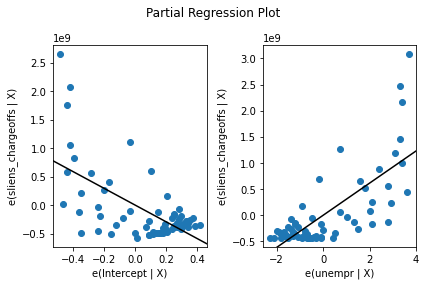

In [17]:
fig = sm.graphics.plot_partregress_grid(model1)
fig.tight_layout(pad=1.0)


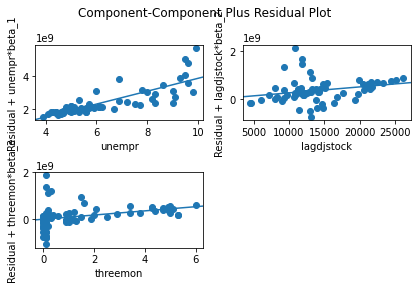

In [18]:
fig = sm.graphics.plot_ccpr_grid(model3)
fig.tight_layout(pad=1.0)


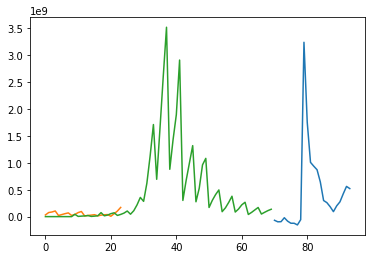

In [19]:
def plot_pred(dep_var, train, test, model):
    y_train = train[f'{dep_var}'].to_list()
    y_test = test[f'{dep_var}'].to_list()
    y_pred = model.predict(test)
    plt.plot(y_pred)
    plt.plot(y_test)
    plt.plot(y_train)
plot_pred('sliens_chargeoffs', train, test, model3)
#set x axis to date list

In [20]:
y_test[20]

7000000.0

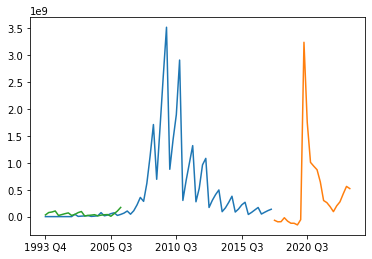

In [21]:
fig, ax = plt.subplots()
ax.plot(y_train)
ax.plot(y_pred)
ax.plot(y_test)



# def format_fn(tick_val, tick_pos):
#     if int(tick_val) in xs:
#         return labels[int(tick_val)]
#     else:
#         return ''

labels = {}
for i in range(len(date)):
    labels[i] = date[i]

def format_fn(tick_val, tick_pos):
    if int(tick_val) >= 0 and int(tick_val) < 94:
        return labels[int(tick_val)]
    else:
        return ''
ax.xaxis.set_major_formatter(format_fn)

plt.show()


In [22]:
# do for others that are more important and make more sense
# ps: you can use the international economic data to analyse vars that have 'foreign' delaings
# also, you have the major csv left - fin basic:)

#### Net Interest Income

In [75]:
def pred_component(norm_df, target, regressors): # netIntInc, list
    reg = "+".join(regressors)
    model = smf.ols(f' {target} ~  {reg}', data=norm_df).fit()
    print(model.summary())
    print("Parameters: ", model.params)
    print("R2: ", model.rsquared)
    fig = sm.graphics.plot_ccpr_grid(model)
    fig.tight_layout(pad=1.0)
    severe = pd.read_csv('../../data/raw/dfast/Severe_Domestic.csv')
    supervisory = pd.read_csv('../../data/raw/dfast/Supervisory_Domestic.csv')
    severe_dates = severe['Date'].to_list()
    pred_severe = severe.iloc[:,2:].astype('float32')
    scaler = MinMaxScaler()
    norm_pred = scaler.fit_transform(pred_severe)
    norm_sev = pd.DataFrame(norm_pred, columns=pred_severe.columns)
    norm_sev = change_names(norm_sev)
    norm_sev = add_lags(norm_sev)
    severe_predictions = model.predict(norm_sev)
    super_dates = supervisory['Date'].to_list()
    pred_super = supervisory.iloc[:,2:].astype('float32')
    scaler = MinMaxScaler()
    norm_pred = scaler.fit_transform(pred_super)
    norm_super = pd.DataFrame(norm_pred, columns=pred_super.columns)
    norm_super = change_names(norm_super)
    norm_super = add_lags(norm_super)
    super_predictions = model.predict(norm_super)
    return severe_predictions, super_predictions


In [ ]:
pred_df = pred_df.rename(columns={'Net interest income': 'netIntInc', 'Pre-tax net operating income': 'preTaxOperInc'})
tar = 'Pre-tax net operating income'
ranks[tar]


                            OLS Regression Results                            
Dep. Variable:              netIntInc   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     15.51
Date:                Sun, 14 Apr 2024   Prob (F-statistic):           6.86e-11
Time:                        23:21:18   Log-Likelihood:                 54.556
No. Observations:                  93   AIC:                            -97.11
Df Residuals:                      87   BIC:                            -81.92
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0263      0.041      0.635

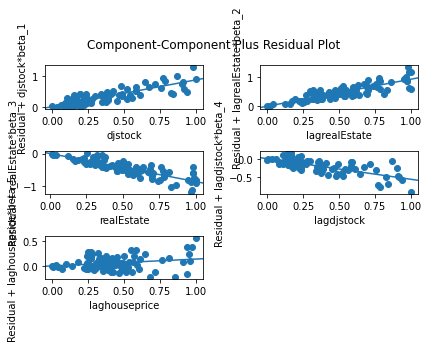

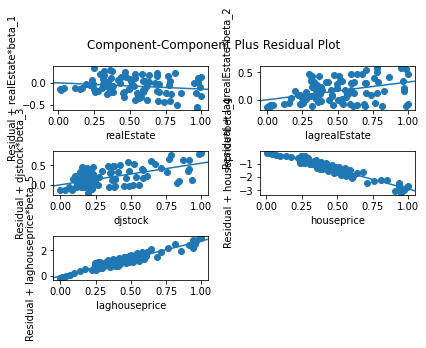

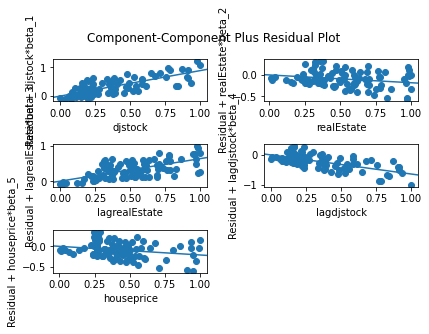

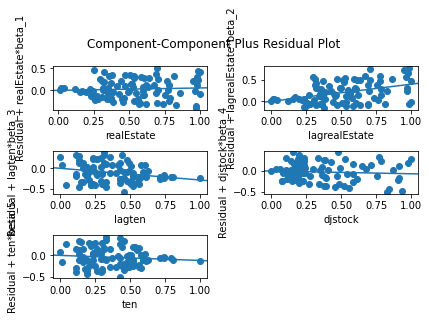

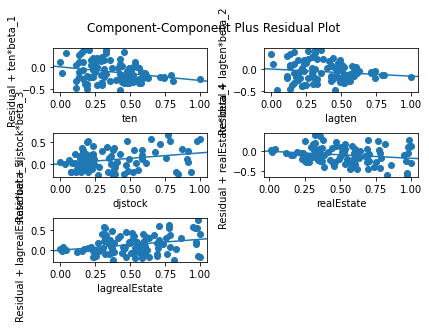

In [210]:
targets_ppnr = {'Net interest income':'netIntInc', 'Total noninterest income':'nonIntInc',
                'Total noninterest expense':'nonIntExp', 'Additional Noninterest Income':'addNonIntInc',
                'Additional noninterest expense':'addNonIntExp'}
targets_ptni = {'Pre-tax net operating income': 'preTaxOperInc',
                    'Provision for loan and lease losses':'loanProvisions', 
                    'Net gains (losses) on sales of loans':'creditLosses', 
                    'Securities gains (losses)':'securityLosses',
                    'Net gains (losses) on sales of other assets (excluding securities)':'otherLosses'}
target_d = targets_ppnr # what d you want to predict
pred_df = pred_df.rename(columns=target_d)
pred_df = pred_df.loc[:,~pred_df.columns.duplicated()].copy()
pred_df['addNonIntInc'] = pd.to_numeric(pred_df['addNonIntInc'])
pred_df['addNonIntExp'] = pd.to_numeric(pred_df['addNonIntExp'])

scaler1 = MinMaxScaler()
norm_pred = scaler1.fit_transform(pred_df)
norm_df = pd.DataFrame(norm_pred, columns=pred_df.columns)


tars = [k for k, v in target_d.items()]
targets = [v for k, v in target_d.items()]
preds = []
for i in range(len(tars)):
    target = targets[i]
    tar = tars[i]
    regressors = [ranks[tar][i][0] for i in range(5)]
    sev, sup = pred_component(norm_df, target, regressors)

    colid = pred_df.columns.get_loc(target)
    scale = MinMaxScaler()
    scale.min_, scale.scale_ = scaler1.min_[colid], scaler1.scale_[colid]
    
    sev_arr = np.array(sev).reshape(-1, 1)
    sev = scale.inverse_transform(sev_arr)
    sup_arr = np.array(sup).reshape(-1, 1)
    sup = scale.inverse_transform(sup_arr)

    preds.append(( target, sev, sup))

# return preds, targets

In [213]:
op = np.array(preds[2][1])
op

array([[           nan],
       [3.03312625e+10],
       [3.55224457e+10],
       [3.59260578e+10],
       [3.57381845e+10],
       [3.22197474e+10],
       [2.96157930e+10],
       [2.49144428e+10],
       [1.94043058e+10],
       [2.04601976e+10],
       [2.51304779e+10],
       [2.83393608e+10],
       [3.07770590e+10]])

In [268]:
[preds[i][0] for i in range(len(preds))]

['netIntInc', 'nonIntInc', 'nonIntExp', 'addNonIntInc', 'addNonIntExp']

In [276]:
severe_ppnr = [preds[0][1][i] + preds[1][1][i] - preds[2][1][i] + preds[3][1][i] - preds[4][1][i] for i in range(13)]
super_ppnr = [preds[0][2][i] + preds[1][2][i] - preds[2][2][i] + preds[3][2][i] - preds[4][2][i] for i in range(13)]
# forget losses
# do loss with timeseries projections - supervisory tests are also stresses afterall
losses = [-super_ppnr[i] + severe_ppnr[i] for i in range(len(super_ppnr))]
loss = 0
for l in losses[1:]:
    # print(l)
    loss += l

loss/10**9 # for 12 quarters projected
# why is severe val higher than supervisory?
sum(severe_ppnr[1:]) # projected ppnr for severe horizons

array([3.39386088e+11])

In [220]:
loss/sum(super_ppnr[1:])
# 52 percent loss projected over 13 quarters:((

array([52.16646694])

Trials

In [251]:
scaler1 = MinMaxScaler()
norm_pred = scaler1.fit_transform(pred_df)
norm_df = pd.DataFrame(norm_pred, columns=pred_df.columns)

In [29]:
# norm_df.head(1)

,realgdp,nomgdp,real_incgrowth,nom_incgrowth,unempr,cpiInflation,threemon,five,ten,corpyeild,...,Other Consumer Loans Net Charge-Offs,Loans to foreign governments and official institutions,Other loans,Lease financing receivables,Loans to finance agricultural production and other loans to farmers,Cash dividends,Cash dividends declared on preferred stock,Cash dividends declared on common stock,Interest income: Foreign office loans,Interest expense: Foreign office deposits
0,0.535032,0.538462,0.363636,0.32679,0.326316,0.66129,0.516667,0.643836,0.712329,0.594595,...,0.021934,0.122581,0.145927,0.009901,0.0,0.006557,0.0,0.006557,0.110592,0.09741


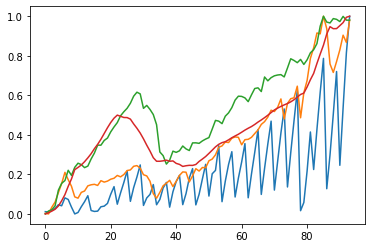

In [252]:
plt.plot(norm_df['preTaxOperInc'])
plt.plot(norm_df['djstock'])
plt.plot(norm_df['realEstate'])
plt.plot(norm_df['houseprice'])

In [253]:
train = norm_df.iloc[:70,:] # inelegant:))
test = norm_df.iloc[70:,:] 


In [254]:

# results = smf.ols(' bny ~  realEstate + dj + cpiInflation + TenYrTreasury + houseprice + FiveYrTreasury', data=train).fit()
model1 = smf.ols(' netIntInc ~  djstock + realEstate + houseprice ', data=train).fit()
model2 = smf.ols(' netIntInc ~  djstock + lagrealEstate', data=train).fit()
model3 = smf.ols(' netIntInc ~  unempr + lagcorpyeild + houseprice', data=train).fit()
model4 = smf.ols(' netIntInc ~  djstock', data=train).fit()
# Inspect the results
model = model1
print(model.summary())
print("Parameters: ", model.params)
print("R2: ", model.rsquared)

                            OLS Regression Results                            
Dep. Variable:              netIntInc   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     7.658
Date:                Sun, 14 Apr 2024   Prob (F-statistic):           0.000182
Time:                        23:47:37   Log-Likelihood:                 60.472
No. Observations:                  70   AIC:                            -112.9
Df Residuals:                      66   BIC:                            -104.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0551      0.033      1.646      0.1

In [255]:
dep_var = 'netIntInc'
# colid = pred_df.columns.get_loc(dep_var)
# scale = MinMaxScaler()
# scale.min_, scale.scale_ = scaler1.min_[colid], scaler1.scale_[colid]

# model = model1
# y_pred = model.predict(test)

# t_arr = np.array(y_pred).reshape(-1, 1)
# y_pred = scale.inverse_transform(t_arr)


[0.017724042758345604,
 0.018524205312132835,
 0.01912706159055233,
 0.04898500442504883,
 0.04579532891511917,
 0.050092071294784546,
 0.05296386778354645,
 0.05788538604974747,
 0.07914985716342926,
 0.0735158771276474,
 0.004768064245581627,
 0.03139249235391617,
 0.05704139173030853,
 0.08293142914772034,
 0.0,
 0.023226501420140266,
 0.04598167538642883,
 0.11126578599214554,
 0.021385041996836662,
 0.06374955922365189,
 0.10530296713113785,
 0.1485334187746048,
 0.02430068515241146,
 0.0725293755531311,
 0.12304893881082535,
 0.17709796130657196,
 0.03590845316648483,
 0.09587644040584564,
 0.1626731902360916,
 0.231947124004364,
 0.04957690089941025,
 0.1262385994195938,
 0.20450063049793243,
 0.32396528124809265,
 0.09218256920576096,
 0.20046694576740265,
 0.3074031174182892,
 0.4126950800418854,
 0.08081593364477158,
 0.17863249778747559,
 0.27750131487846375,
 0.3725995421409607,
 0.07195939868688583,
 0.17063093185424805,
 0.2684693932533264,
 0.36999082565307617,
 0.077385

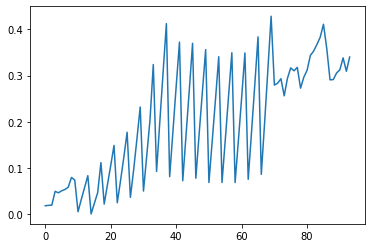

In [256]:
y_train = train[f'{dep_var}'].to_list()
y_test = test[f'{dep_var}'].to_list()
y_pred = model.predict(test)
for val in y_pred:
    y_train.append(val)
plt.plot(y_train)
# plt.plot(y_test)
# plt.plot(y_pred)
y_train

In [257]:
test[f'{dep_var}']

70    0.097466
71    0.221655
72    0.348737
73    0.479897
74    0.111079
75    0.303983
76    0.464771
77    0.623005
78    0.136115
79    0.286851
80    0.427569
81    0.572299
82    0.116604
83    0.255283
84    0.398424
85    0.547144
86    0.128562
87    0.296672
88    0.497863
89    0.731202
90    0.216273
91    0.468662
92    0.730511
93    1.000000
Name: netIntInc, dtype: float32

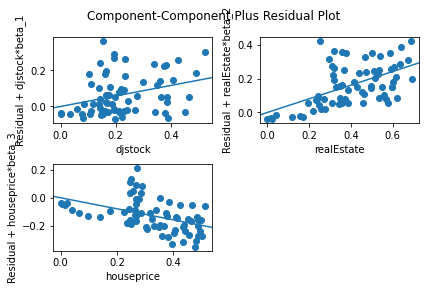

In [258]:
fig = sm.graphics.plot_ccpr_grid(model)
fig.tight_layout(pad=1.0)

### Scenarios

In [259]:
severe = pd.read_csv('../../data/raw/dfast/Severe_Domestic.csv')
supervisory = pd.read_csv('../../data/raw/dfast/Supervisory_Domestic.csv')


In [260]:
severe_dates = severe['Date'].to_list()
pred_severe = severe.iloc[:,2:].astype('float32')
scaler = MinMaxScaler()
norm_pred = scaler.fit_transform(pred_severe)
norm_sev = pd.DataFrame(norm_pred, columns=pred_severe.columns)
norm_sev = change_names(norm_sev)
norm_sev = add_lags(norm_sev)
severe_predictions = model.predict(norm_sev)


In [261]:
severe_predictions.sum()

1.9859310157976988

In [262]:
super_dates = supervisory['Date'].to_list()
pred_super = supervisory.iloc[:,2:].astype('float32')
scaler = MinMaxScaler()
norm_pred = scaler.fit_transform(pred_super)
norm_super = pd.DataFrame(norm_pred, columns=pred_super.columns)
norm_super = change_names(norm_super)
norm_super = add_lags(norm_super)
super_predictions = model.predict(norm_super)

In [263]:
colid = pred_df.columns.get_loc('nonIntInc')
scale = MinMaxScaler()
scale.min_, scale.scale_ = scaler1.min_[colid], scaler1.scale_[colid]

sev_arr = np.array(severe_predictions).reshape(-1, 1)
sev = scale.inverse_transform(sev_arr)
sup_arr = np.array(super_predictions).reshape(-1, 1)
sup = scale.inverse_transform(sup_arr)


In [267]:
( - sup.sum() + sev.sum())/10**9
# sev.sum()/10**9

65.79625764393994

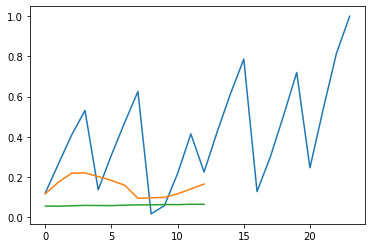

In [68]:
y_test = test['preTaxOperInc'].to_list()
plt.plot(y_pred)
plt.plot(y_test)
plt.plot(severe_predictions)
plt.plot(super_predictions)
#shift and change indices

### VAR

In [ ]:
# Pre-tax net operating income